## NMC Assignment - Max Santos

In [405]:
# Import necessary modules

# Data manipulation
import pandas as pd
import numpy as np
import xlrd

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Display
from IPython.display import HTML

In [406]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
*For ease of reading, the code in this notebook has been hidden.
To toggle on/off, and to see the code click <a href="javascript:code_toggle()">here</a>.''')

--- 

## Importing Data

First, I will import all three data files and convert them to dataframe format. For the Workforce data, I have decided to use the full-time equivalent (FTE) data, as I believe this will provide more useful information than headcount. However, for future analyses, headcount count also be analysed. 

#### Number of Trusts per dataset:

In [407]:
# Read in the data files 

SHMI_data = pd.read_csv('SHMI Diagnosis Data Deaths associated with hospitalisation England April 2017 - March 2018.csv')

geo_data = pd.read_excel('Geo Location Data.xls', sheet_name='Geo Location Data')

workforce_data = pd.read_excel('nhs_workforce_statistics__december_2017_organisation_tables (modified).xlsx', 
                               sheet_name='2. HEE Org Main Staff Gp FTE', 
                               header= 6, skiprows= [7,8,9,10], skipfooter= 16)

In [408]:
# Data cleaning for Workforce file

workforce_data.reset_index(inplace= True)
workforce_data.dropna(axis=1, how='all', inplace= True)
workforce_data.drop(['level_0', 'level_1'], axis=1, inplace= True)
workforce_data.rename(columns={'level_2': 'PROVIDER_NAME', 'level_3': 'PROVIDER_CODE'}, inplace=True)

# Remove all empty rows (identified by ones that are missing the 'PROVIDER_NAME' variable)

provider_nan = list(workforce_data[workforce_data['PROVIDER_NAME'].isnull()].index)

workforce_data = workforce_data.drop(provider_nan)

# Convert float values to integers

workforce_data = workforce_data.round(0)
workforce_data = workforce_data.astype(int, errors= 'ignore')

In [409]:
print('Geo data:',geo_data['EmployerCode ODS'].nunique())
print('SHMI data:',SHMI_data['PROVIDER_CODE'].nunique())
print('Workforce data:',workforce_data['PROVIDER_CODE'].nunique())

Geo data: 130
SHMI data: 131
Workforce data: 428


The above data shows that the workforce table includes many more trusts than required. This is because the workforce data includes 'CCGs' which are not within NMC systems. 

The 'EmployerCode ODS' column from the Geo Dataset gives a way of identifying all of the 130 hospitals that are within NMC systems. Therefore, I will use these values to select the relevant trusts for the analysis. 

#### Merging datasets in to one main table (code here)

In [410]:
# Joining Tables
print('Shape (rows, columns) of data: \n')
print('Geo Data:' ,geo_data.shape)
print('SHMI Data:' ,SHMI_data.shape)
print('Workforce Data:' ,workforce_data.shape)

Shape (rows, columns) of data: 

Geo Data: (130, 15)
SHMI Data: (18292, 8)
Workforce Data: (428, 29)


In [411]:
nmc_data = pd.merge(SHMI_data, geo_data, left_on= 'PROVIDER_CODE', right_on= 'EmployerCode ODS', how='inner')
nmc_data = pd.merge(nmc_data, workforce_data, on= 'PROVIDER_CODE', how='inner')

In [412]:
# Tidy up table, remove duplicate columns or and columns with 1 unique value

cols_to_drop = ['INDICATOR_CODE', 'PROVIDER_NAME_y', 'EmployerCode ODS', 'EmployerName', 'Country_code']
nmc_data.drop(cols_to_drop, axis=1, inplace= True)
nmc_data.rename(columns={'PROVIDER_NAME_x': 'PROVIDER_NAME', 'Total': 'Total Workforce'}, inplace=True)

# Missing SPELLS and OBSERVED values are currently represented with '*'. Convert this to NaN

nmc_data.replace('*', np.nan, inplace=True)

#### Missing Data

The table below shows the proportion of missing values in the main table. 

In [413]:
# Find missing data

total = nmc_data.isnull().sum().sort_values(ascending=False)
percent = (100*nmc_data.isnull().sum()/nmc_data.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage Missing'])
missing_data.head()

,Total,Percentage Missing
OBSERVED,7205,39.693
Admin_county_code,3075,16.940
SPELLS,435,2.396
Other staff or those with unknown classification,0,0.000
NHS_regional_HA_code,0,0.000


The OBSERVED column contains how many deaths occurred, and approx 40% of these values are missing, which is a large amount of observations (or 'rows') to discard from the dataset. 

However, without the OBSERVED variable, the observations provide no meaningful or useful information (as it is not possible to calculate an SHMI value without OBSERVED). Therefore, all observations with a missing OBSERVED value will be removed from the dataset prior to analysis.  

### Adding SHMI Feature

The SHMI value (or mortality rate) is defined as:

**SHMI = OBSERVED / EXPECTED**

This feature will be added to each observation in the dataset, as it is the variable that this analysis is most concerned with. 

In [414]:
# Remove all rows that are missing the 'OBSERVED' variable

observed_nan = list(nmc_data[nmc_data['OBSERVED'].isnull()].index)

nmc_data = nmc_data.drop(observed_nan)

In [415]:
# Impute missing 'SPELLS' values using the mean of column

nmc_data['SPELLS'] = nmc_data['SPELLS'].astype(float)

nmc_data['SPELLS'].fillna((nmc_data['SPELLS'].mean()), inplace=True)

In [416]:
# Before adding SHMI feature, convert SPELLS and OBSERVED to integer values

nmc_data['SPELLS'] = nmc_data['SPELLS'].astype(int, errors='ignore')
nmc_data['OBSERVED'] = nmc_data['OBSERVED'].astype(int)

# Adding SHMI feature
nmc_data['SHMI'] = nmc_data['OBSERVED'] / nmc_data['EXPECTED']

In [417]:
# One value of SHMI is showing as NaN (still unsure as why... so will drop observation)

SHMI_nan = list(nmc_data[nmc_data['SHMI'].isnull()].index)

nmc_data = nmc_data.drop(SHMI_nan)

### Categorising SHMI

The NHS have a method of categorising SHMI values in to 'higher than expected', 'as expected' and 'lower than expected' using 'Control Limits'. For this analysis, and for simplicity, the SHMI values will be categorised as follows:

**Lower than expected:** SHMI < 0.89

**Higher than expected:** SHMI > 1.12

**As expected:** any value not within the ranges stated above.

In [418]:
#Create 'SHMI Level' column 

nmc_data['SHMI Level'] = 'As expected'
nmc_data.loc[nmc_data['SHMI'] < 0.89, 'SHMI Level'] = 'Lower'
nmc_data.loc[nmc_data['SHMI'] > 1.12, 'SHMI Level'] = 'Higher'


nmc_data.head()

,DIAGNOSIS_GROUP_NUMBER,DIAGNOSIS_GROUP_DESCRIPTION,PROVIDER_CODE,PROVIDER_NAME,SPELLS,OBSERVED,EXPECTED,EmployerFullAddress,EmployerPostCode,NHS_HA_code,Eastings,Northings,NHS_regional_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code,Sector,Name_of_Board_2018,NMC_Region,Total Workforce,Professionally qualified clinical staff,HCHS Doctors,Consultant (including Directors of Public Health),Associate Specialist,Specialty Doctor,Staff Grade,Specialty Registrar,Core Training,Foundation Doctor Year 2,Foundation Doctor Year 1,Hospital Practitioner / Clinical Assistant,Other and Local HCHS Doctor Grades,Nurses & health visitors,Midwives,Ambulance staff,"Scientific, therapeutic & technical staff",Support to clinical staff,"Support to doctors, nurses & midwives",Support to ambulance staff,Support to ST&T staff,NHS infrastructure support,Central functions,"Hotel, property & estates",Senior managers,Managers,Other staff or those with unknown classification,SHMI,SHMI Level
0,1,Tuberculosis,REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST,564,0,0.001,"UNIVERSITY HOSPITAL AINTREE, FAZAKERLEY HOSPIT...",L9 7AL,E18000002,336758,396959,E19000001,0,E08000012,E05000897,L9,North West,North West,4351,2277,552,233,5,15,1,133,66,48,50,1,0,1135,2,0,588,1245,1003,0,242,828,307,396,39,86,2,0.000,Lower
1,2,"Septicaemia (except in labour), Shock",REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST,1543,279,294.664,"UNIVERSITY HOSPITAL AINTREE, FAZAKERLEY HOSPIT...",L9 7AL,E18000002,336758,396959,E19000001,0,E08000012,E05000897,L9,North West,North West,4351,2277,552,233,5,15,1,133,66,48,50,1,0,1135,2,0,588,1245,1003,0,242,828,307,396,39,86,2,0.947,As expected
3,4,Mycoses,REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST,14,0,0.767,"UNIVERSITY HOSPITAL AINTREE, FAZAKERLEY HOSPIT...",L9 7AL,E18000002,336758,396959,E19000001,0,E08000012,E05000897,L9,North West,North West,4351,2277,552,233,5,15,1,133,66,48,50,1,0,1135,2,0,588,1245,1003,0,242,828,307,396,39,86,2,0.000,Lower
5,6,Non-HIV related infections,REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST,270,0,1.689,"UNIVERSITY HOSPITAL AINTREE, FAZAKERLEY HOSPIT...",L9 7AL,E18000002,336758,396959,E19000001,0,E08000012,E05000897,L9,North West,North West,4351,2277,552,233,5,15,1,133,66,48,50,1,0,1135,2,0,588,1245,1003,0,242,828,307,396,39,86,2,0.000,Lower
6,7,Cancer of head and neck,REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST,474,15,15.323,"UNIVERSITY HOSPITAL AINTREE, FAZAKERLEY HOSPIT...",L9 7AL,E18000002,336758,396959,E19000001,0,E08000012,E05000897,L9,North West,North West,4351,2277,552,233,5,15,1,133,66,48,50,1,0,1135,2,0,588,1245,1003,0,242,828,307,396,39,86,2,0.979,As expected


## Data Visualisation

### Distribution of SHMI

In [419]:
trace = go.Box(x= nmc_data['SHMI'], name= 'SHMI', boxpoints='all')

layout = go.Layout(title= 'Distribution of SHMI values')

data = [trace]

fig = go.Figure(data, layout= layout)

iplot(fig)

In [420]:
x = nmc_data['SHMI']

trace = go.Histogram(x= x, opacity=0.75, name = 'SHMI')

data = [trace]
layout = go.Layout(title='Distribution of SHMI values',height=600, barmode='overlay', xaxis=dict(title='SHMI',range=[0, 8]))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

These plots show that the SHMI values (for all diagnoses and trusts) follow a normal distribution. However, there is a very large peak at 0, due to observations where no observed deaths occurred. This peak will need to be considered when calculating (or averaging) the SHMI over groups of observations. 

The shape of a normal distribution can be seen even more clearly with these zero-values removed. The data is also slightly skewed, with a long tail at the upper end.

In [421]:
x = nmc_data[nmc_data['SHMI'] != 0]['SHMI']

trace = go.Histogram(x= x, opacity=0.75, name = 'SHMI')

data = [trace]
layout = go.Layout(title='Distribution of SHMI values (zero values removed)',height=600, barmode='overlay', xaxis=dict(title='SHMI',range=[0, 8]))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [422]:
x = np.asarray(nmc_data[nmc_data['SHMI'] != 0]['SHMI'].values)

hist_data = [x]

label = ['SHMI']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, label, show_hist=False, show_rug=False)

# Add title
fig['layout'].update(title='Distribution of SHMI values (zero values removed)')
fig['layout'].update(xaxis=dict(title='SHMI',range=[0, 8]))

# Plot
iplot(fig)

## Grouping data by Diagnosis Group

Here I will group the data by diagnosis group, to see if there is a trend between SHMI and certain diagnoses.

When grouping the data, I will aggregate over the OBSERVED and EXPECTED columns, and use these totals to calculate a new SHMI value for each diagnosis. This is far more suitable than using either the mean or median, as the large peak of zero-values will skew any average made, which would be misleading. 

In the code, the newly calculated SHMI values, from the aggregated data, will be labeled as 'SHMI (agg.)'.

In [423]:
# Grouping data by diagnosis (summing over observed & expected)

diagnosis_agg = nmc_data.groupby(['DIAGNOSIS_GROUP_NUMBER', 'DIAGNOSIS_GROUP_DESCRIPTION']).sum()
diagnosis_agg.reset_index(inplace= True)

# Calculating new SHMI value, one per diagnosis
# SHMI is calculated using aggregated observed and expected values (name 'SHMI (agg.)')

diagnosis_agg['SHMI (agg.)'] = diagnosis_agg['OBSERVED'] / diagnosis_agg['EXPECTED']

diagnosis_agg['SHMI (agg.) Level'] = 'As expected'
diagnosis_agg.loc[diagnosis_agg['SHMI (agg.)'] < 0.89, 'SHMI (agg.) Level'] = 'Lower'
diagnosis_agg.loc[diagnosis_agg['SHMI (agg.)'] > 1.12, 'SHMI (agg.) Level'] = 'Higher'

diagnosis_agg.drop(['SHMI'], axis=1, inplace= True)

diagnosis_agg_sort = diagnosis_agg.sort_values(by=['SHMI (agg.)'])

In [424]:
trace = go.Box(x= diagnosis_agg['SHMI (agg.)'], name= 'SHMI')

layout = go.Layout(title= 'Distribution of SHMI by Diagnosis Group', xaxis= dict(title='SHMI', range=[0, 1.6]))

data = [trace]

fig = go.Figure(data, layout= layout)

iplot(fig)

In [425]:
x = diagnosis_agg['SHMI (agg.)']

trace = go.Histogram(x= x, opacity=0.75, name = 'SHMI')

data = [trace]
layout = go.Layout(title='Distribution of SHMI by Diagnosis Group',height=600, barmode='overlay', xaxis=dict(title='SHMI',range=[0, 1.6]))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

The plots above show a similar trend, with a normal distribution (albeit less distinct), and a small peak at zero. Due to the zero-values being included in the aggregation, a long tail (now at the *lower* end) has appeared.

In [426]:
def shmi_scatter(dataframe, shmi_column, variable_column, shmi_level, title):
    
    x1= dataframe[dataframe[shmi_level] == 'Lower'][variable_column]
    x2= dataframe[dataframe[shmi_level] == 'As expected'][variable_column]
    x3= dataframe[dataframe[shmi_level] == 'Higher'][variable_column]

    y1= dataframe[dataframe[shmi_level] == 'Lower'][shmi_column]
    y2= dataframe[dataframe[shmi_level] == 'As expected'][shmi_column]
    y3= dataframe[dataframe[shmi_level] == 'Higher'][shmi_column]


    trace1 = go.Scatter(
        y = y1,
        x = x1,
        mode='markers',
        name='Lower than expected',
        marker=dict(
            size=8
        )
    )

    trace2 = go.Scatter(
        y = y2,
        x = x2,
        mode='markers',
        name='As expected',
        marker=dict(
            size=8
        )
    )

    trace3 = go.Scatter(
        y = y3,
        x = x3,
        mode='markers',
        name='Higher than expected',
        marker=dict(
            size=8
        )
    )
    
    colors=['#2ca02c', '#1f77b4', '#d62728']

    data = [trace1, trace2, trace3]
    
    layout = dict(title='{}'.format(title), margin=dict(l=50), width=1000, height=600, 
                  yaxis=dict(title='SHMI'), colorway=colors)

    fig = go.Figure(data, layout=layout)
    iplot(fig)

In [427]:
shmi_scatter(diagnosis_agg_sort, 'SHMI (agg.)', 'DIAGNOSIS_GROUP_DESCRIPTION', 'SHMI (agg.) Level', 'SHMI by Diagnosis Group')

This plot shows how the different diagnosis groups are distributed by SHMI level. The 'lower than expected values' have a particularly large range, with the 'as expected' values being very closely grouped. This could be used as an indicator to which diagnosis groups are more at risk from a high SHMI level, which is also demonstrated in the table below.

### Top 20 Diagnosis Groups by SHMI value

In [428]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

diagnosis_agg.nlargest(20, 'SHMI (agg.)')[['DIAGNOSIS_GROUP_NUMBER', 'DIAGNOSIS_GROUP_DESCRIPTION', 'SHMI (agg.)']].reset_index(drop=True)

,DIAGNOSIS_GROUP_NUMBER,DIAGNOSIS_GROUP_DESCRIPTION,SHMI (agg.)
0,67,Other cerebrovascular disease,1.466
1,134,Syncope,1.416
2,133,Other injuries & conditions due to external ca...,1.402
3,125,Crushing injury or internal injury,1.384
4,44,Other psychoses,1.379
5,119,Other perinatal conditions,1.370
6,138,Abdominal pain,1.321
7,127,Open wounds of extremities,1.302
8,114,"Rheumatoid arthritus related diseases, acquire...",1.298
9,132,Poisoning,1.284


## Grouping Data by Trust

Here I will group the data by Trust (or hospital), using the same method as was used when grouping by Diagnosis. The first table below shows an example of how the data looks once grouped by trust.

In [429]:
# Group data by Trust, summing over OBSERVED and EXPECTED to calculate new SHMI

trusts_shmi = nmc_data.groupby(['PROVIDER_CODE']).sum()
trusts_shmi.reset_index(inplace= True)
trusts_shmi = trusts_shmi[['PROVIDER_CODE','SPELLS','OBSERVED','EXPECTED']]

# Adding SHMI feature

trusts_shmi['SHMI (agg.)'] = trusts_shmi['OBSERVED'] / trusts_shmi['EXPECTED']
trusts_shmi['SHMI (agg.) Level'] = 'As expected'
trusts_shmi.loc[trusts_shmi['SHMI (agg.)'] < 0.89, 'SHMI (agg.) Level'] = 'Lower'
trusts_shmi.loc[trusts_shmi['SHMI (agg.)'] > 1.12, 'SHMI (agg.) Level'] = 'Higher'

trusts_shmi.head()

,PROVIDER_CODE,SPELLS,OBSERVED,EXPECTED,SHMI (agg.),SHMI (agg.) Level
0,R1F,15788,790,734.572,1.075,As expected
1,R1H,100076,3706,4083.173,0.908,As expected
2,R1K,64124,2509,3002.988,0.836,Lower
3,RA2,34686,1032,1264.431,0.816,Lower
4,RA3,16705,769,787.719,0.976,As expected


In [430]:
hospital_data = nmc_data.groupby(['PROVIDER_CODE']).first().reset_index()
hospital_data.drop(['DIAGNOSIS_GROUP_NUMBER', 'DIAGNOSIS_GROUP_DESCRIPTION', 'SPELLS', 'OBSERVED', 
                    'EXPECTED', 'SHMI', 'SHMI Level'], axis=1, inplace=True)

In [431]:
trusts_data = pd.merge(trusts_shmi, hospital_data, 
                         on= 'PROVIDER_CODE', how='inner')

trusts_data_sort = trusts_data.sort_values(by=['SHMI (agg.)'])


In [432]:
trace = go.Box(x= trusts_data['SHMI (agg.)'], name= 'SHMI')

layout = go.Layout(title= 'Distribution of SHMI by Trust', xaxis= dict(title='SHMI', range=[0.6, 1.4]))

data = [trace]

fig = go.Figure(data, layout= layout)

iplot(fig)

In [433]:
x = trusts_data['SHMI (agg.)']

trace = go.Histogram(x= x, opacity=0.75, name = 'SHMI')

data = [trace]
layout = go.Layout(title='Distribution of SHMI by Trust',height=600, barmode='overlay', xaxis=dict(title='SHMI',range=[0.6, 1.4]))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

These plots show a much more distinctive normal shape (when compared to the diagnosis plots), and with a very similar median value (at around 1.02). 

In [434]:
shmi_scatter(trusts_data_sort, 'SHMI (agg.)', 'PROVIDER_CODE', 'SHMI (agg.) Level', 'SHMI by Trust')

This plot shows how the different Trusts are distributed by SHMI level. The 'lower than expected values' again have a large range, and the 'as expected' values have a much higher spread than before. This plot could again be used as an indicator to which Trusts are more at risk from a high SHMI level, which are shown in the table below.

### Top 20 Trusts by SHMI value

In [435]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

trusts_data.nlargest(20, 'SHMI (agg.)')[['PROVIDER_CODE', 'PROVIDER_NAME', 'SHMI (agg.)']].reset_index(drop=True)

,PROVIDER_CODE,PROVIDER_NAME,SHMI (agg.)
0,RE9,SOUTH TYNESIDE NHS FOUNDATION TRUST,1.251
1,RL4,THE ROYAL WOLVERHAMPTON NHS TRUST,1.242
2,RVY,SOUTHPORT AND ORMSKIRK HOSPITAL NHS TRUST,1.205
3,RBD,DORSET COUNTY HOSPITAL NHS FOUNDATION TRUST,1.195
4,RJL,NORTHERN LINCOLNSHIRE AND GOOLE NHS FOUNDATION...,1.180
5,RGP,JAMES PAGET UNIVERSITY HOSPITALS NHS FOUNDATIO...,1.171
6,RMP,TAMESIDE AND GLOSSOP INTEGRATED CARE NHS FOUND...,1.167
7,RQW,THE PRINCESS ALEXANDRA HOSPITAL NHS TRUST,1.165
8,RWD,UNITED LINCOLNSHIRE HOSPITALS NHS TRUST,1.162
9,RRF,"WRIGHTINGTON, WIGAN AND LEIGH NHS FOUNDATION T...",1.158


### Correlation between SHMI and other variables

The heatmap below can be used to see the correlation between SHMI and other variables in the data (by looking at the top row specifically). There aren't any variables that have a particularly high correlation. Below I will visualise some of these correlations, but I will focus on the variables that are more relevant to the NMC (such as nurse and midwife support levels).

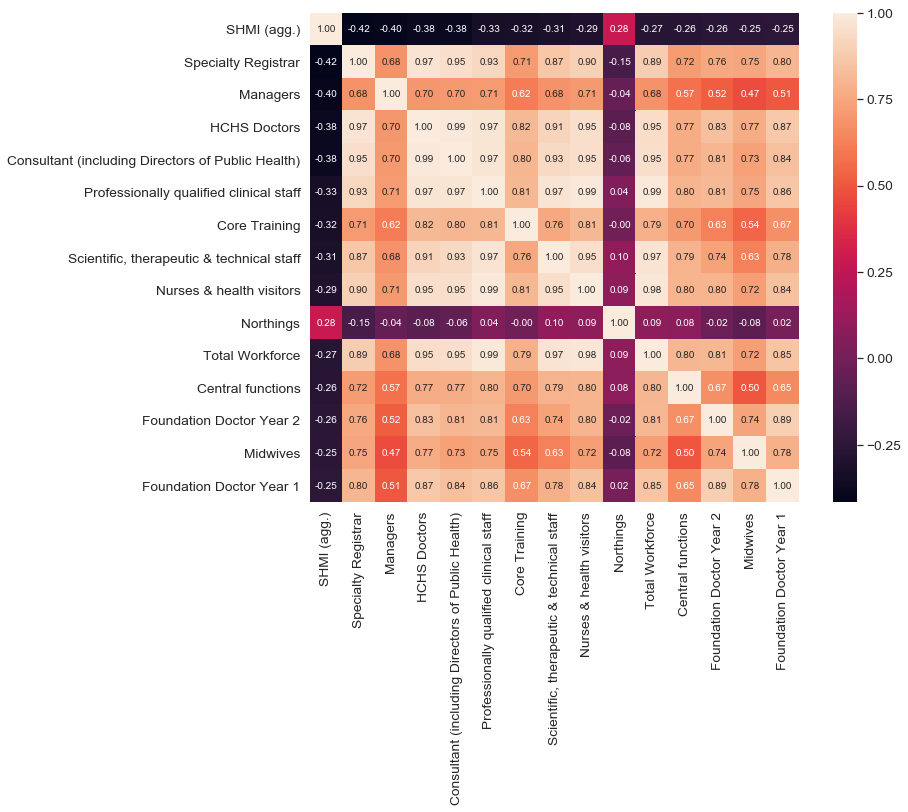

In [436]:
#shmi correlation matrix with most ABSOLUTE correlated variables
matrix = trusts_data.corr()

k = 15 #number of variables for heatmap
abs_cols = abs(matrix).nlargest(k, 'SHMI (agg.)')['SHMI (agg.)'].index
cm = np.corrcoef(trusts_data[abs_cols].values.T)
fig, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=abs_cols.values, xticklabels=abs_cols.values)
plt.show()

In [437]:
def shmi_correlation(dataframe, shmi_column, variable_column, shmi_level, title):
    
    x1= dataframe[dataframe[shmi_level] == 'Lower'][variable_column]
    x2= dataframe[dataframe[shmi_level] == 'As expected'][variable_column]
    x3= dataframe[dataframe[shmi_level] == 'Higher'][variable_column]

    y1= dataframe[dataframe[shmi_level] == 'Lower'][shmi_column]
    y2= dataframe[dataframe[shmi_level] == 'As expected'][shmi_column]
    y3= dataframe[dataframe[shmi_level] == 'Higher'][shmi_column]


    trace1 = go.Scatter(
        y = y1,
        x = x1,
        mode='markers',
        name='Lower than expected',
        marker=dict(
            size=8
        )
    )

    trace2 = go.Scatter(
        y = y2,
        x = x2,
        mode='markers',
        name='As expected',
        marker=dict(
            size=8
        )
    )

    trace3 = go.Scatter(
        y = y3,
        x = x3,
        mode='markers',
        name='Higher than expected',
        marker=dict(
            size=8
        )
    )

    colors=['#2ca02c', '#1f77b4', '#d62728']
    
    data = [trace1, trace2, trace3]
    
    layout = dict(title='{}'.format(title), margin=dict(l=50), width=1000, height=600, 
                  yaxis=dict(title='SHMI'), xaxis=dict(title='{}'.format(variable_column)), 
                 colorway=colors)

    fig = go.Figure(data, layout=layout)
    iplot(fig)

### Correlation between SHMI and Staff Levels

### Scatter Plots

The follow scatter plots do not appear to show much correlation (by eye) between the variables. The boxplots in the next section are far more suitable for demonstrating this, however, I have decided to include these plots for reference.

In [438]:
shmi_correlation(trusts_data, 'SHMI (agg.)', 'Total Workforce', 'SHMI (agg.) Level', 'SHMI vs Total Workforce')

In [439]:
shmi_correlation(trusts_data, 'SHMI (agg.)', 'Nurses & health visitors', 'SHMI (agg.) Level', 'SHMI vs Nurses')

In [440]:
shmi_correlation(trusts_data, 'SHMI (agg.)', 'Midwives', 'SHMI (agg.) Level', 'SHMI vs Midwives')

In [441]:
shmi_correlation(trusts_data, 'SHMI (agg.)', 'Support to doctors, nurses & midwives', 'SHMI (agg.) Level', 'SHMI vs Support to nurses & midwives')

In [442]:
def shmi_box(variable):
    y1= trusts_data_sort[trusts_data_sort['SHMI (agg.) Level'] == 'Lower'][variable]
    y2= trusts_data_sort[trusts_data_sort['SHMI (agg.) Level'] == 'As expected'][variable]
    y3= trusts_data_sort[trusts_data_sort['SHMI (agg.) Level'] == 'Higher'][variable]

    trace1 = go.Box(y=y1, name='Lower')
    trace2 = go.Box(y=y2, name='As expected')
    trace3 = go.Box(y=y3, name='Higher')


    colors=['#2ca02c', '#1f77b4', '#d62728']

    layout = go.Layout(title='Distribution of SHMI by {}'.format(variable), 
                       xaxis=dict(title='SHMI Level'), yaxis=dict(title='{}'.format(variable)), colorway=colors)

    data = [trace1, trace2, trace3]

    fig = go.Figure(data, layout=layout)

    iplot(fig)

### Box Plots

These box plots show a much clearer relationship between staff levels and SHMI level. As expected, higher staff levels appear to have a positive effect in reducing the SHMI level in a Trust.

In [443]:
shmi_box('Midwives')

In [444]:
shmi_box('Nurses & health visitors')

In [445]:
shmi_box('Total Workforce')

In [446]:
shmi_box('Support to doctors, nurses & midwives')

### Calculating Nurses per staff

Here I have calculated a new feature, 'Nurses per staff', which is calculated as:

**Nurses per staff = Nurses & health visitors / Total Workforce**

I felt that this may be a more useful feature to include, as it shows the proportion of staff compared to the size of the Trust, as opposed to just looking at an absolute value.

In [447]:
trusts_data_sort['Nurses per staff'] = trusts_data_sort['Nurses & health visitors'] / trusts_data_sort['Total Workforce']

In [448]:
shmi_box('Nurses per staff')

From this data (particularly the scatter plots) it can also be seen that there are some hospitals with low staff levels and a high SHMI. This would suggest that these hospitals are in need of more staff.

However, it is also clear that there are some hospitals with (comparatively) very high staff levels, but also a high SHMI. This suggests that these hospitals (and their staff) may be in need of support.

## SHMI by Geographic Location

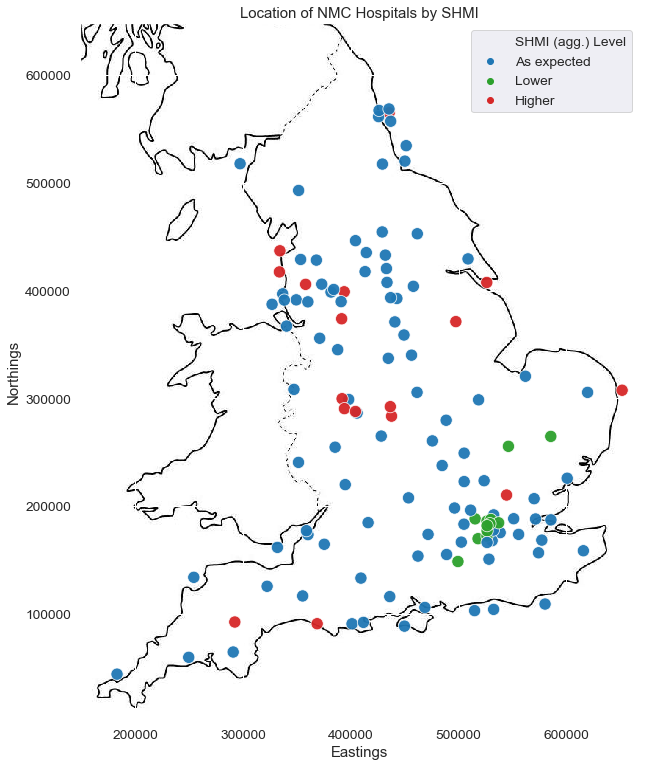

In [449]:
#sns.set_palette('muted')
palette = sns.color_palette(['#1f77b4', '#2ca02c', '#d62728'])

img = plt.imread("ukmap cropped.jpg")
fig, ax = plt.subplots(figsize=(10,13))
ax.imshow(img, extent=[149000, 667000, 2000, 648000])
ax = sns.scatterplot(x="Eastings", y="Northings", 
                     hue="SHMI (agg.) Level", alpha=0.95, 
                     s=150, data=trusts_data, palette=palette).set_title('Location of NMC Hospitals by SHMI')

Note: A similar visualisation to above could be created using tools such as PowerBI, which would possibly be more suitable and have the advantage of being interactive. However, for this assessment I have decided to focus on the use of Python and containing all analysis to one notebook.

The plot above shows the distribution of NMC hospitals across the UK. There is a very clear cluster of green 'Lower than expected' hospitals in the London region.

There is also a cluster of red 'Higher than expected' hospitals in the Birmingham, Liverpool and Manchester areas. This could be important information for the NMC to consider, as it may point to differences in the way that hospitals are run (or funded) regionally, which may be impacting on SHMI levels.